## ENOT: Expectile Regularization for Fast and Accurate Training of Neural Optimal Transport

{class}`~ott.neural.solvers.expectile_neural_dual.ExpectileNeuralDual` solves the dual OT problem where the objective is a sum 
of Kantorovich potential functions with additional expectile regularisation {cite}`buzun:24`. Initialisation arguments includes potential models that inherit {class}`~flax.linen.Module`, a cost function of type {class}`~ott.geometry.costs.CostFn` `is_bidirectional` boolean parameter that indicates whether we train the OT mapping in both directions, and two regularisation parameters (`expectile` and `expectile_loss_coef`). The training procedure returns object {class}`~ott.problems.linear.potentials.DualPotentials` that can be used to transport betweet input distributions or compute the corresponding OT distance between them. 

In [3]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [14]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import dataclasses
from typing import Callable, Sequence
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from ott import datasets
from ott.datasets import Dataset
from ott.geometry import costs
from ott.geometry import pointcloud
from ott.tools import sinkhorn_divergence

## Evaluation on synstethic 2D datasets

In this section we show how ENOT finds optimal map between two measures constructed from {cite}`makkuva:20`. Here, we utilize `~ott.datasets.create_gaussian_mixture_samplers` in order to get samples from source measure `square_five` and target measure `square_four`.
`ExpectileNeuralDual` class implements neural optimal transport training pipeline along with expectile regularization. In experiments we used custom implementation of `MLP` which provides additional flexibility by turning off addition of Squared Euclidean norm. Under the hood optimization is done with respect to provided form of cost function (either in the form of dot product or as translation invariant cost `TICost`).

Also, we additionally use `plotly` library for visualizations, which can be installed via `pip install plotly`

In [68]:
num_samples_visualize = 512
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = datasets.create_gaussian_mixture_samplers(
    name_source="square_five",
    name_target="square_four",
    valid_batch_size=num_samples_visualize,
    train_batch_size=2048
)

eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

In [69]:
def vizualize_measures(eval_data_source, eval_data_target):
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(
        go.Scatter(
            x=eval_data_source[:, 0],
            y=eval_data_source[:, 1],
            mode="markers",
            marker_color="LightSkyBlue",
            name="Source",
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=eval_data_target[:, 0],
            y=eval_data_target[:, 1],
            mode="markers",
            marker_color="red",
            name="Target",
        ),
        row=1,
        col=2,
    )
    fig.update_layout(
        title_text="Examples of two measures", title_font_size=25, title_x=0.5
    )
    fig.update_traces(marker=dict(size=8, line=dict(width=0.8, color="black")))
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


vizualize_measures(eval_data_source, eval_data_target)

In [58]:
def training_callback(step, learned_potentials):
    if step % 2500 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        neural_dual_dist = learned_potentials.distance(eval_data_source, eval_data_target)
        print(
            f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
        )

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)

## Training

Here, by setting `is_bidirectional` flag in `ExpectileNeuralDual` class to `True`, we compute OT in back and forth fashion. The main hyperparameters to look at are `expectile` and `expectile_loss_coef`, denoted in paper as $\tau$ and $\lambda$ respectively.

Training iteration: 90000/90001
Neural dual distance between source and target data: 21.22


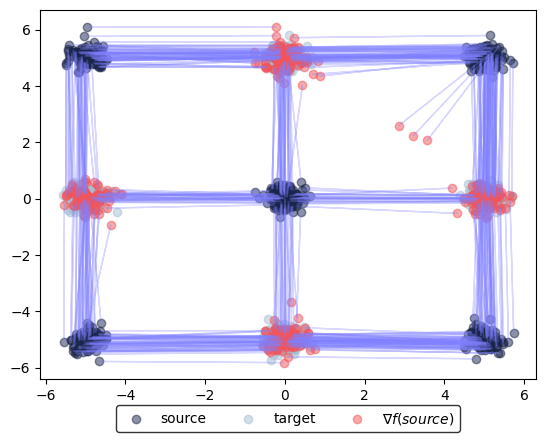

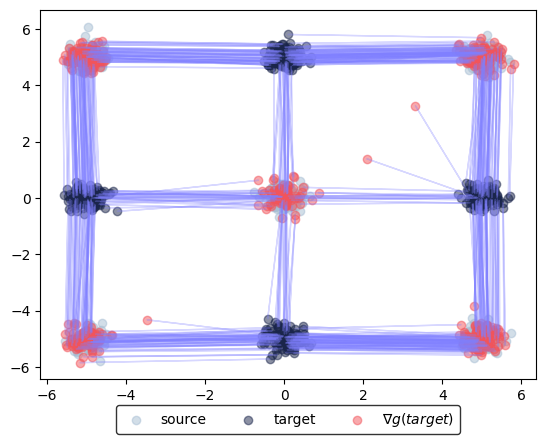

In [72]:
from ott.neural.solvers.expectile_neural_dual import MLP, ExpectileNeuralDual

num_train_iters = 90_001

neural_f = MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.gelu)
neural_g = MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.gelu)

lr_schedule_f = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)

neural_dual_solver = ExpectileNeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    cost_fn=costs.SqEuclidean(),
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=0.3,
    rng=jax.random.PRNGKey(3),
    is_bidirectional=True,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)

In [29]:
@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv.divergence

In [73]:
pred_target = learned_potentials.transport(eval_data_source)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_loss(pred_target, eval_data_target):.2f}"
)

pred_source = learned_potentials.transport(eval_data_target, forward=False)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

neural_dual_dist = learned_potentials.distance(
    eval_data_source, eval_data_target
)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
)

sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")

Sinkhorn distance between target predictions and data samples: 0.09
Sinkhorn distance between source predictions and data samples: 0.09
Neural dual distance between source and target data: 21.22
Sinkhorn distance between source and target data: 21.24


## MafMoons & Rings synthetic datasets

Below we show how expectile regularization behaves on more challenging tasks. For such case we implement `MAFMoon` and `Ring` datasets.

In [74]:
import sklearn

@dataclasses.dataclass
class MAFMoonSampler:
    def __init__(self, size):
        self.size = size

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        x = jax.random.normal(key, shape=[batch_size, 2])
        x = x.at[:, 0].add(x[:, 1] ** 2)
        x = x.at[:, 0].mul(0.5)
        x = x.at[:, 0].add(-5)
        return x


@dataclasses.dataclass
class RingSampler:
    def __init__(self, size):
        self.size = size

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        n_samples4 = n_samples3 = n_samples2 = batch_size // 4
        n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

        linspace4 = jnp.linspace(0, 2 * jnp.pi, n_samples4, endpoint=False)
        linspace3 = jnp.linspace(0, 2 * jnp.pi, n_samples3, endpoint=False)
        linspace2 = jnp.linspace(0, 2 * jnp.pi, n_samples2, endpoint=False)
        linspace1 = jnp.linspace(0, 2 * jnp.pi, n_samples1, endpoint=False)

        circ4_x = jnp.cos(linspace4) * 1.2
        circ4_y = jnp.sin(linspace4) * 1.2
        circ3_x = jnp.cos(linspace4) * 0.9
        circ3_y = jnp.sin(linspace3) * 0.9
        circ2_x = jnp.cos(linspace2) * 0.55
        circ2_y = jnp.sin(linspace2) * 0.55
        circ1_x = jnp.cos(linspace1) * 0.25
        circ1_y = jnp.sin(linspace1) * 0.25

        X = (
            jnp.vstack(
                [
                    jnp.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
                    jnp.hstack([circ4_y, circ3_y, circ2_y, circ1_y]),
                ]
            ).T
            * 3.0
        )
        X = sklearn.utils.shuffle(X)

        # Add noise
        X = X + jax.random.normal(key, shape=X.shape) * 0.08

        return X.astype("float32")

In [75]:
train_loader = Dataset(
    source_iter=iter(MAFMoonSampler(size=1024)),
    target_iter=iter(RingSampler(size=1024)),
)
valid_loader = train_loader

moon_samples = next(train_loader.source_iter)
ring_samples = next(train_loader.target_iter)

vizualize_measures(moon_samples, ring_samples)

Training iteration: 90000/90001
Neural dual distance between source and target data: 22.02


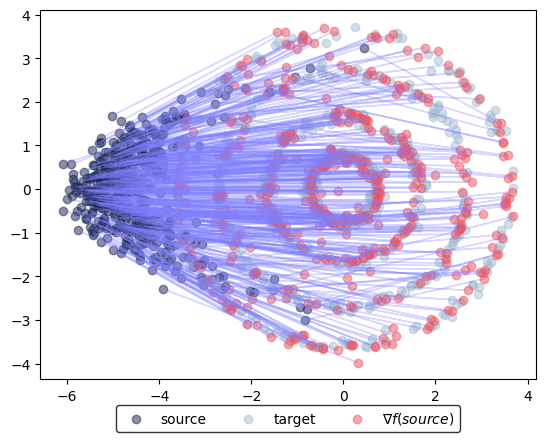

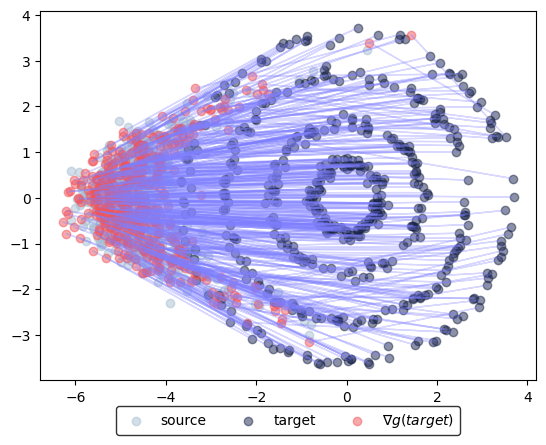

In [76]:
num_samples_visualize = 512
eval_data_source = next(valid_loader.source_iter)[:num_samples_visualize]
eval_data_target = next(valid_loader.target_iter)[:num_samples_visualize]

def training_callback(step, learned_potentials):
    if step % 2500 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        neural_dual_dist = learned_potentials.distance(
            eval_data_source, eval_data_target
        )
        print(
            f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
        )

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)


neural_f = MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)
neural_g = MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)

num_train_iters = 90_001
lr_schedule_f = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-3
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-3
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)

neural_dual_solver = ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    cost_fn=costs.SqEuclidean(),
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=0.3,
    rng=jax.random.PRNGKey(4),
    is_bidirectional=True,
)
learned_potentials = neural_dual_solver(
    *train_loader,
    *valid_loader,
    callback=training_callback
)

Evaluate `learned_potentials`

In [77]:
def vizualize_measures_with_ground_truth(
    eval_data_source, pushforward, eval_data_target
):
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(
        go.Scatter(
            x=eval_data_source[:, 0],
            y=eval_data_source[:, 1],
            mode="markers",
            marker_color="LightSkyBlue",
            name="Source",
            marker=dict(size=8, line=dict(width=0.8, color="black")),
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=pushforward[:, 0],
            y=pushforward[:, 1],
            mode="markers",
            marker_color="red",
            name="Pushforward of Source",
            marker=dict(size=5, line=dict(width=0.8, color="black")),
        ),
        row=1,
        col=2,
    )
    fig.add_trace(
        go.Scatter(
            x=eval_data_target[:, 0],
            y=eval_data_target[:, 1],
            mode="markers",
            marker_color="green",
            name="GroundTruth Target",
            opacity=0.45,
            marker=dict(size=5, line=dict(width=0.8, color="black")),
        ),
        row=1,
        col=2,
    )
    fig.update_layout(
        title_text="Examples of two measures", title_font_size=25, title_x=0.5
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


vizualize_measures_with_ground_truth(
    moon_samples, learned_potentials.transport(moon_samples), ring_samples
)

## Different costs on 2D data

Below we show how ENOT performs with varying undrelying cost function $c(x, y)$ on synthetic 2d datasets `HalfMoon` and `S_curve`. Run cells below to generate datasets. 

In [80]:
from types import MappingProxyType
from typing import Any, Iterator, Literal, Mapping, Optional, Tuple
import sklearn.datasets


@dataclasses.dataclass
class SklearnDistribution:
    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.Array] = None

    def __iter__(self) -> Iterator[jnp.ndarray]:
        """Random sample generator from Gaussian mixture.

        Returns:
        A generator of samples from the Gaussian mixture.
        """
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.PRNGKey(0) if self.rng is None else self.rng

        # define rotation matrix tp rotate samples
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                x, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = x[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 256,
    valid_batch_size: int = 256,
    rng: Optional[jax.Array] = None,
) -> Tuple[datasets.Dataset, datasets.Dataset, int]:

    rng = jax.random.PRNGKey(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

In [81]:
def plot_samples(
    train_source: Any,
    train_target: Any,
    num_points: Optional[int] = None,
    learned_potentials: Any = None,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (8, 6),
    rng: Optional[jax.Array] = None,
):
    rng = jax.random.PRNGKey(0) if rng is None else rng
    fig, ax = plt.subplots(figsize=figsize)
    subsample_source = jax.random.choice(
        rng, a=len(train_source), shape=(num_points,)
    )
    subsample_target = jax.random.choice(
        rng, a=len(train_target), shape=(num_points,)
    )
    ax.scatter(
        train_source[subsample_source, 0],
        train_source[subsample_source, 1],
        label="source",
        c="b",
        edgecolors="k",
        s=300,
        alpha=0.8,
    )
    ax.scatter(
        train_target[subsample_target, 0],
        train_target[subsample_target, 1],
        label="target",
        c="r",
        edgecolors="k",
        marker="X",
        s=300,
        alpha=0.6,
    )
    if learned_potentials is not None:
        mapped_source = learned_potentials.transport(
            train_source[subsample_source], forward=True
        )
        ax.scatter(
            mapped_source[:, 0],
            mapped_source[:, 1],
            label="push-forward",
            c="orange",
            edgecolors="k",
            marker="X",
            s=300,
            alpha=0.8,
        )
        z = mapped_source - train_source[subsample_source]
        ax.quiver(
            train_source[subsample_source, 0],
            train_source[subsample_source, 1],
            z[:, 0],
            z[:, 1],
            angles="xy",
            scale_units="xy",
            scale=1.0,
            width=0.003,
            headwidth=10,
            headlength=10,
            color="dodgerblue",
            edgecolor="k",
            alpha=0.5,
        )
    ax.set_title(title, fontsize=20, y=1.01)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.legend(fontsize=16, loc="lower left")
    plt.axis("off")
    fig.tight_layout()
    plt.show()

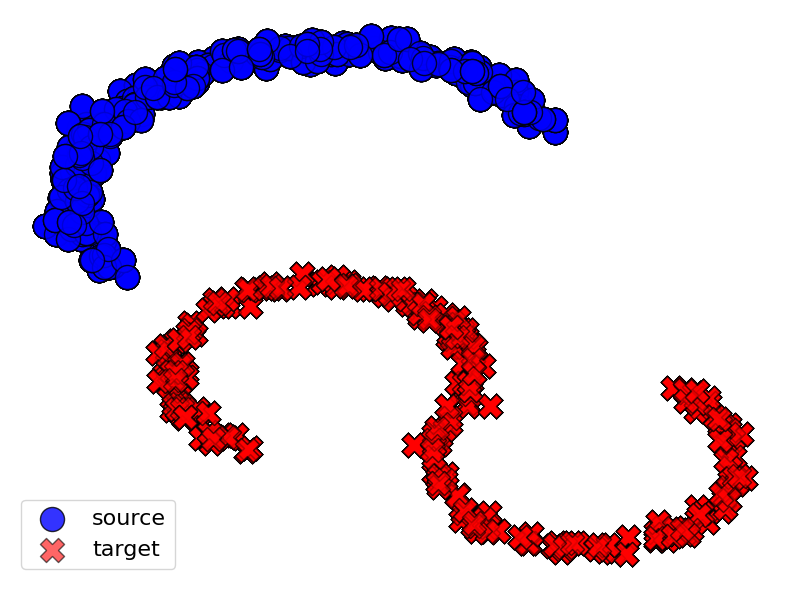

In [82]:
train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.05,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([0.5, -2.0]),
        "theta_rotation": -jnp.pi / 6,
        "noise": 0.05,
    },
)

train_source = next(train_dataset.source_iter)
train_target = next(train_dataset.target_iter)
plot_samples(train_source, train_target, num_points=5_000)

In [83]:
neural_f = MLP(dim_hidden=[64, 64, 64, 2], act_fn=jax.nn.gelu)
neural_g = MLP(dim_hidden=[64, 64, 64, 1], act_fn=jax.nn.gelu)

num_train_iters = 25_001

lr_schedule_f = optax.cosine_decay_schedule(
    init_value=3e-4, decay_steps=num_train_iters, alpha=1e-4
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=3e-4, decay_steps=num_train_iters, alpha=1e-4
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)


neural_dual_solver = ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.Euclidean(),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)

learned_potentials = neural_dual_solver(
    *train_dataset,
    *valid_dataset
)

  0%|          | 0/25001 [00:00<?, ?it/s]

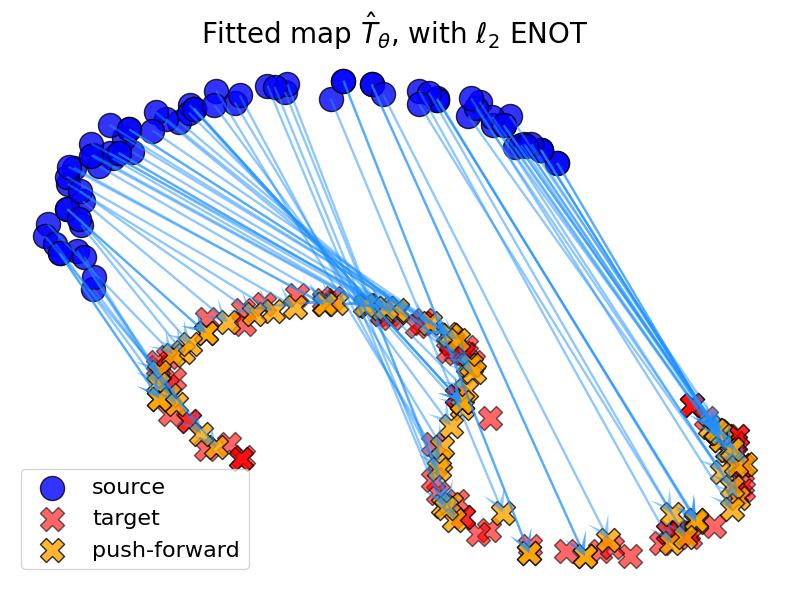

In [84]:
plot_samples(
    train_source,
    train_target,
    learned_potentials=learned_potentials,
    title=r"Fitted map $\hat{T}_\theta$, with $\ell_2$ ENOT",
    num_points=80,
)

Change cost to squared Euclidean and vizualize results:

In [85]:
neural_dual_solver = ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.SqEuclidean(),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)

learned_potentials = neural_dual_solver(
    *train_dataset,
    *valid_dataset
)

  0%|          | 0/25001 [00:00<?, ?it/s]

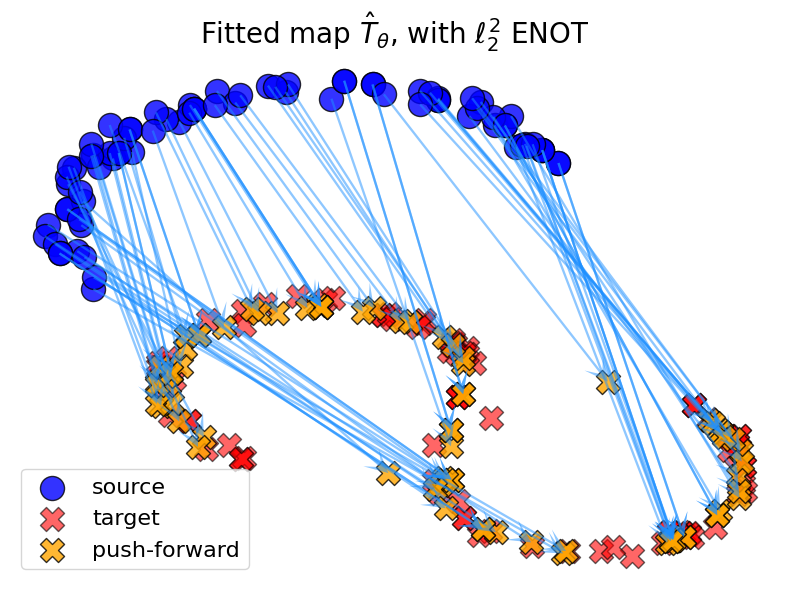

In [86]:
plot_samples(
    train_source,
    train_target,
    learned_potentials=learned_potentials,
    title=r"Fitted map $\hat{T}_\theta$, with $\ell^2 _2$ ENOT",
    num_points=80,
)

In [88]:
neural_dual_solver = ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.PNormP(1.5),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)

learned_potentials = neural_dual_solver(
    *train_dataset,
    *valid_dataset
)

  0%|          | 0/25001 [00:00<?, ?it/s]

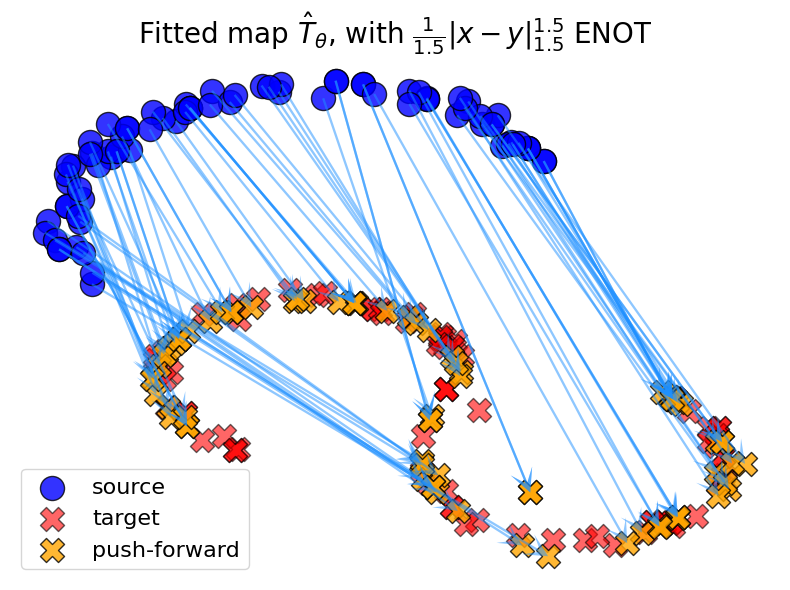

In [89]:
plot_samples(
    train_source,
    train_target,
    learned_potentials=learned_potentials,
    title=r"Fitted map $\hat{T}_\theta$, with $\frac{1}{1.5}|x-y|^{1.5} _{1.5}$ ENOT",
    num_points=80,
)